In [1]:
import numpy as np
np.seterr(all='raise')
import sys
sys.path.append('../')

from meshmaker.base import Base, Laziness
from meshmaker.model import Model
from meshmaker.mesh import Mesh
from meshmaker.pmesh import ParamMesh, MetaMesh, MetaScene
from meshmaker.meta import Railing, Stairs
from meshmaker.tform import TForm
from meshmaker.vec3 import vec3
from meshmaker.quat import quat
from meshmaker.planargraph import planargraph
from meshmaker.geometry import batch, slide, loop_normal, isnear, near
#from meshmaker.geometry import batch, slide, loop_offset, loop_normal, loop_contains, loop_split, isnear, near, loopO
from meshmaker.mgl import show, MainShader, EdgeShader, WireShader
from meshmaker.plt import *
from collections import defaultdict
from functools import partial
import json

show = partial(show, programs=[MainShader(), EdgeShader(), WireShader(color=vec3.U())])

In [5]:
class Railing(MetaMesh):

    """Provide a control mesh with a `_railings` attribute"""

    def simple(self, u, v):
        x, y = u + vec3.Z(0.4), v + vec3.Z(0.4)
        mesh = Mesh.prism([u, v, y, x], 0.05, 0.0)
        mesh.uvs = mesh.vertex_uvs(
            O=(u, vec3.O()), S=vec3.U() * 2,
            seams=mesh.angle_seams())
        return TForm.from_meshes(mesh)

    def scene(self):
        chunks = []
        for u, v in self.control._railings:
            u = u if isinstance(u, vec3) else self.control.vertices[u]
            v = v if isinstance(v, vec3) else self.control.vertices[v]
            chunks.append(self.simple(u, v))
        return TForm(children=chunks)

In [9]:
class Stairs(MetaMesh):
    
    # TODO: support edge to edge staircases
    
    def switchback(self, u, v, z, m):
        u, v, w = u, u.lerp(v, 0.5), v
        
        N = vec3.Z().crs(v - u).nrm()
        
        dz = (u.z - z)
        dZ = vec3.Z(dz)
        dH = vec3.Z(0.1)
        dy = (u.d(w) / 2)
        
        o = N * (m * abs(dz / 2)) - dZ * 0.5
        p, q, r = u + o, v + o, w + o
        a, b = u.lerp(v, 0.5), p.lerp(q, 0.5)
        ll = [a, b, b - dH, a - dH]
        a, b = v.lerp(w, 0.5) - dZ, q.lerp(r, 0.5)
        rl = [a, b, b - dH, a - dH]
        ml = [q, q + N * dy, q + N * dy - dH, q - dH]
        meshes = (Mesh.prism(ll, u.d(v)),
                  Mesh.prism(rl, v.d(w)),
                  Mesh.prism(ml, u.d(w)))

        for mesh in meshes:
            mesh.uvs = mesh.vertex_uvs(
                O=(u, vec3.O()), S=vec3.U() * 2,
                seams=mesh.angle_seams())
        
        self.control._railings.append((p, u))
        self.control._railings.append((v, q))
        self.control._railings.append((p + N * dy, p))
        self.control._railings.append((r + N * dy, p + N * dy))
        self.control._railings.append((r, r + N * dy))
        self.control._railings.append((q, v - dZ))
        self.control._railings.append((w - dZ, r))
        self.control._railings.append((v - dZ, v - dZ - N * 0.1))
        self.control._railings.append((w - dZ - N * 0.1, w - dZ))
        return TForm.from_meshes(*meshes)
    
    def simple(self, u, v, p, q):
        a, b = u.lerp(v, 0.5), p.lerp(q, 0.5)
        l = [a, b, b - vec3.Z(0.1), a - vec3.Z(0.1)]
        mesh = Mesh.prism(l, u.d(v))
        mesh.uvs = mesh.vertex_uvs(
            O=(u, vec3.O()), S=vec3.U() * 2,
            seams=mesh.angle_seams())
        N = vec3.Z().crs(u - v).nrm()
        self.control._railings.append((u, p))
        self.control._railings.append((p, p + N * 0.1))
        self.control._railings.append((q, v))
        self.control._railings.append((q + N * 0.1, q))
        steps = self.steps(p, q, v, u)
        return TForm.from_meshes(mesh).add(steps).parent
    
    def steps(self, a, b, c, d, stepheight=0.1):
        r = a.d(d)
        z = d.z - a.z
        n = int(abs(z) / stepheight)
        lb = a.line(d, n, True)
        rb = b.line(c, n, True)
        if z < 0:
            lb.reverse()
            rb.reverse()
        h = lb[1].d(lb[0])
        z = lb[1].z - lb[0].z
        t = np.arccos(z / h)
        dX = vec3.Z().crs(b - a).nrm() * (h * np.sin(t))
        steps = Mesh()
        steps.uvs = {}
        for (aa, bb), (cc, dd) in slide(list(zip(lb, rb)), 2, 1):
            if d.z > a.z:
                O = cc - dX
                front = steps.af([aa, bb, dd - dX, cc - dX])
                top   = steps.af([cc - dX, dd - dX, dd, cc])
            else:
                O = dd + dX
                front = steps.af([bb, aa, cc + dX, dd + dX])
                top   = steps.af([dd + dX, cc + dX, cc, dd])
            seams = steps.perimeter((front, top))
            steps.unwrap_uvs(top, O=(O, vec3.O()), S=vec3.U(2),
                             seams=seams, uvs=steps.uvs)
        return TForm.from_meshes(steps)
    
    def place(self, u, v, w=1, align=1.0):
        if (u, v) in self.control._railings:
            self.control._railings.remove((u, v))
        u = self.control.vertices[u] if isinstance(u, int) else u
        v = self.control.vertices[v] if isinstance(v, int) else v
        d = u.d(v)
        dx = w / 2 / d
        x = near(near(align, 1, dx), 0, dx)
        if d > w:
            if x == 0:
                u_ = v - (v - u).nrm() * w
                self.control._railings.append((u, u_))
                #self.control._railings.append((u, u_.lerp(v, 0.5)))
                u = u_
            elif x == 1:
                v_ = u + (v - u).nrm() * w
                self.control._railings.append((v_, v))
                v = v_
            else:
                u_ = u.lerp(v, x - dx)
                v_ = u.lerp(v, x + dx)
                self.control._railings.append((u, u_))
                self.control._railings.append((v_, v))
                u = u_
                v = v_
        return u, v
    
    def scene(self):
        vs, fs = self.control.vertices, self.control.faces
        
        chunks = []
        
        w = 1.5
        x = 0.6
        m = 2.0
        #z = 0.0
        #z = vs[fs[self.patch[0]][0]].z
        sb = False
        
        wires = []
        
        for i, (tip, tail) in enumerate(self.control._stairs):

            z = vs[fs[tip][0]].z
            u, v = tail

            u, v = self.place(u, v, w, x)

            wires.append([u, v])
            
            if sb:
                chunks.append(self.switchback(v, u, z, m))
            
            else:
                
                N = vec3.Z().crs(u - v).nrm()
                p = u + N * (m * abs(u.z - z)) - vec3.Z(u.z - z)
                q = v + N * (m * abs(v.z - z)) - vec3.Z(v.z - z)

                chunks.append(self.simple(u, v, p, q))
                #chunks.append(self.simple(v, u, z, m))

        guide = Mesh()
        guide.wires = lambda tf: [tf.transform(wire) for wire in wires]
        guide = Model(meshes={'generic_0': [guide]})

        return TForm(children=chunks, models=[guide])

In [7]:
class WallFactory(Base):

    @staticmethod
    def safeloop(al, bl):
        X = (al[ 1] - al[0]).nrm()
        Y = (al[-1] - al[0]).nrm()
        N = X.crs(Y)
        dN = N * ((N.dot(al[0]) - N.dot(bl[1])) / 2)
        sl = [p - dN for p in al]
        sd = bl[1].dot(X) - al[0].dot(X)
        if sd > 0:
            sl[0].trn(X * sd)
            sl[3].trn(X * sd)
        sd = bl[0].dot(X) - al[1].dot(X)
        if sd < 0:
            sl[1].trn(X * sd)
            sl[2].trn(X * sd)
        sd = bl[1].dot(Y) - al[0].dot(Y)
        if sd > 0:
            sl[0].trn(Y * sd)
            sl[1].trn(Y * sd)
        sd = bl[3].dot(Y) - al[2].dot(Y)
        if sd < 0:
            sl[2].trn(Y * sd)
            sl[3].trn(Y * sd)
        return sl
        
    @staticmethod
    def hole(u, v, x, w, h, z):
        T = (v - u).nrm()
        x = u.lerp(v, x) + vec3.Z(z)
        Z = vec3.Z(h)
        hole = [x - T * (w / 2)    , x + T * (w / 2),
                x + T * (w / 2) + Z, x - T * (w / 2) + Z]
        return hole
    
    @classmethod
    def doorhole(cls, sl, x, w=0.4, h=0.8):
        return cls.hole(sl[0], sl[1], x, w, h, 0.02)
    
    @classmethod
    def windowhole(cls, sl, x, w=0.3, h=0.5):
        return cls.hole(sl[0], sl[1], x, w, h, 0.3)
    
    @staticmethod
    def embed(loop, holes):
        N = loop_normal(loop)
        for hole in holes:
            dN = N * (loop[0].dot(N) - hole[0].dot(N))
            dN.trnps(hole)
        return loop, holes

    @staticmethod
    def borders(loop, ldx, rdx, ldy, rdy, X, Y):
        a, b, c, d = loop
        ldY = vec3.Z(ldy)
        rdY = vec3.Z(rdy)
        ldX = (b - a).nrm() * ldx
        rdX = (b - a).nrm() * rdx
        chunks = []
        if ldx > 0:
            chunks.append([a + ldY, a + ldY + ldX, d - rdY + ldX, d - rdY])
            if ldy > 0:
                chunks.append([a.cp(), a + ldX, a + ldY + ldX, a + ldY])
            if rdy > 0:
                chunks.append([d - rdY, d - rdY + ldX, d + ldX, d.cp()])
        if rdx > 0:
            chunks.append([b + ldY - rdX, b + ldY, c - rdY, c - rdY - rdX])
            if ldy > 0:
                chunks.append([b - rdX, b.cp(), b + ldY, b + ldY - rdX])
            if rdy > 0:
                chunks.append([c - rdY - rdX, c - rdY, c.cp(), c - rdX])
        if ldy > 0:
            chunks.append([a + ldX, b - rdX, b - rdX + ldY, a + ldX + ldY])
        if rdy > 0:
            chunks.append([d + ldX - rdY, c - rdX - rdY, c - rdX, d + ldX])
        return chunks
        
    @staticmethod
    def tiles(loop, 
              chunk_w=1.01, chunk_h=1.01, 
              x_align=1.0, y_align=1.0, 
              max_nx=None, max_ny=None):
        """Chunk a rectangular space into a grid"""
        assert (x_align >= 0.0 and x_align <= 2.0)
        assert (y_align >= 0.0 and y_align <= 2.0)
        lw = loop[0].d(loop[ 1])
        lh = loop[0].d(loop[-1])
        nx = int(lw / chunk_w)
        ny = int(lh / chunk_h)
        nx = nx if max_nx is None else min(max_nx, nx)
        ny = ny if max_ny is None else min(max_ny, ny)
        X = (loop[ 1] - loop[0]).nrm()
        Y = (loop[-1] - loop[0]).nrm()
        dx = near((lw - nx * chunk_w) / 2, 0)
        dy = near((lh - ny * chunk_h) / 2, 0)
        positions = []
        if nx > 0 and ny > 0:
            for x in range(0, nx):
                x = x * chunk_w + dx * x_align
                for y in range(0, ny):
                    y = y * chunk_h + dy * y_align
                    positions.append(loop[0] + X * x + Y * y)
        return positions, (dx, dy, X, Y)
        
    @staticmethod
    def fliploop(loop):
        return [loop[1].cp(), loop[0].cp(), loop[3].cp(), loop[2].cp()]
        
    def tileable(self, w, h, d, ltex='generic_12', rtex='generic_13',
                 window=False, door=False, **kws):
        l = [vec3(0,-d, 0), vec3(w,-d, 0), vec3(w,-d, h), vec3(0,-d, h)]
        r = [vec3(w, d, 0), vec3(0, d, 0), vec3(0, d, h), vec3(w, d, h)]
        N = kws.get('N', vec3.nY())

        if door:
            lh = [self.doorhole(l, 0.4)]
            rh = [self.fliploop(self.doorhole(r, 0.6))]
        elif window:
            lh = [self.windowhole(l, 0.4)]
            rh = [self.fliploop(self.windowhole(r, 0.6))]
        else:
            lh, rh = [], []
        
        meshes = defaultdict(list)
        
        if ltex:
            ml = Mesh()
            ml.apy((l, lh))
            meshes[ltex].append(ml)
        if rtex:
            mr = Mesh()
            mr.apy((r, rh))
            meshes[rtex].append(mr)
        mm = Mesh()
        for lhole, rhole in zip(lh, rh):
            mm.bridge(lhole, rhole)
        meshes['generic_11'].append(mm)
        
        #mesh.uvs = mesh.unwrap_uvs(seams=mesh.angle_seams())
        return TForm(models=[Model(meshes)], chunk_N=N)
        
    def _get_cached(self, chunk_w=1, chunk_h=1, chunk_d=0.1):
        def tile(**kws):
            tf = self.tileable(chunk_w, chunk_h, chunk_d / 2, **kws)
            tf.chunk_w = chunk_w
            tf.chunk_h = chunk_h
            tf.chunk_d = chunk_d
            return tf
        itex, etex = 'generic_2', 'generic_13'
        cached = {
            'i_1' : tile(ltex=itex, rtex=None),
            'i__1' : tile(ltex=itex, rtex=None, window=True),
            'e_1' : tile(ltex=etex, rtex=None),
            'ie_1': tile(ltex=itex, rtex=etex, window=True),
            'ii_1': tile(ltex=itex, rtex=itex, door=True),
            'ee_1': tile(ltex=etex, rtex=etex),
                }
        return cached
        
    def metas(self, cached=None, x_align=1.0, y_align=0.0, max_nx=None, max_ny=None,
              fill_texture='generic_4', debug=True, debug_texture='generic_8'):        
        
        def metaf(control, faces):
            if len(faces) == 1:
                af, = faces
                al = [control.vertices[v] for v in control.faces[af]]
                bl = None
                sl = [p.cp().trn(loop_normal(al) * -(cached.chunk_d / 2)) for p in al]
            elif len(faces) == 2:
                af, bf = faces
                al = [control.vertices[v] for v in control.faces[af]]
                bl = [control.vertices[v] for v in control.faces[bf]]
                sl = self.safeloop(al, bl)
            
            positions, (dx, dy, X, Y) = self.tiles(sl, cached.chunk_w, cached.chunk_h,
                                                   x_align, y_align, max_nx, max_ny)
            borders = []
            if positions:
                sN = loop_normal(sl)
                if cached.chunk_N.isnear(sN):
                    q = None
                elif cached.chunk_N.isnear(sN.fp()):            
                    q = quat.av(-np.pi, vec3.Z())
                else:
                    q = quat.uu(cached.chunk_N, sN)
                chunks = [TForm(t=t, q=q) for t in positions]
                for tf in chunks:
                    tf.add(cached.cp())
                if al:
                    ldx =     (x_align) * dx + near((X.dot(sl[ 0]) - X.dot(al[ 0])), 0)
                    rdx = (2 - x_align) * dx + near((X.dot(al[ 1]) - X.dot(sl[ 1])), 0)
                    ldy =     (y_align) * dy + near((Y.dot(sl[ 0]) - Y.dot(al[ 0])), 0)
                    rdy = (2 - y_align) * dy + near((Y.dot(al[-1]) - Y.dot(sl[-1])), 0)
                    borders.extend(self.borders(al, ldx, rdx, ldy, rdy, X, Y))
                if bl:
                    X = X.fp()
                    ldx = (2 - x_align) * dx + near((X.dot(sl[ 1]) - X.dot(bl[ 0])), 0)
                    rdx =     (x_align) * dx + near((X.dot(bl[ 1]) - X.dot(sl[ 0])), 0)
                    ldy =     (y_align) * dy + near((Y.dot(sl[ 0]) - Y.dot(bl[ 0])), 0)
                    rdy = (2 - y_align) * dy + near((Y.dot(bl[-1]) - Y.dot(sl[-1])), 0)
                    borders.extend(self.borders(bl, ldx, rdx, ldy, rdy, X, Y))
            else:
                chunks  = []
                if al:
                    borders.append(al)
                if bl:
                    borders.append(bl)

            fill = Mesh()
            for border in borders:
                fill.af(border)
            fill = Model(meshes={fill_texture: [fill]})
            
            if debug:
                if sl is not None:
                    dZ = vec3.Z(0)
                    pl = self.fliploop(sl)
                    dbg = Mesh()
                    dbg.af(dZ.trnps(vec3(1, 1, 1).sclps([p.cp() for p in sl])))
                    dbg.af(dZ.trnps(vec3(1, 1, 1).sclps([p.cp() for p in pl])))
                    dbg = Model(meshes={debug_texture: [dbg]})
                    chunks.append(TForm(models=[dbg]))
                    
            #chunks.append(TForm(t=sl[0].lerp(sl[1], 0.5), q=q,
            #                    models=[Model.cube_model('generic_8', r=0.2)]))
            
            return TForm(children=chunks, models=[fill])

        return metaf
    
def test():
    wf = NewWallFactory()

    d = 0.2
    tiles = wf._get_cached(1, 1, d)

    a = [vec3(-0.2,-d,-0.2), vec3(1.8,  -d,-0.2), vec3(1.8,-d, 1), vec3(-0.2,  -d, 1)]
    b = [vec3( 1.2, 0.0, 0), vec3(  0, 0.0,   0), vec3(0, 0.0, 2), vec3( 1.2, 0.0, 2)]
    w = dict(loops=[a, b], doors=[], exterior=False)
    

    samples = []

    # wall factory produces meta feature using repeatable tile
    #  meta feature encodes doors, windows, randomization of the wall
    # create meshes combining the meta feature with loop pairs
    
    mesh = Mesh()
    meta = wf.metas(tiles['ie_1'])
    mesh.af(a, meta=meta)
    mesh.af(b, meta=meta)
    samples.append(mesh)

    mesh = Mesh()
    meta = wf.metas(tiles['ie_1'])
    mesh.af(b, meta=meta)
    mesh.af(a, meta=meta)
    samples.append(mesh)

    mesh = Mesh()
    meta = wf.metas(tiles['ii_1'])
    mesh.af(a, meta=meta)
    mesh.af(b, meta=meta)
    samples.append(mesh)

    mesh = Mesh()
    meta = wf.metas(tiles['ii_1'])
    mesh.af(b, meta=meta)
    mesh.af(a, meta=meta)
    samples.append(mesh)

    mesh = Mesh()
    meta = wf.metas(tiles['i_1'])
    mesh.af(a, meta=meta)
    samples.append(mesh)

    mesh = Mesh()
    meta = wf.metas(tiles['i_1'])
    mesh.af(b, meta=meta)
    samples.append(mesh)
    
    mesh = Mesh()
    meta = wf.metas(tiles['e_1'])
    mesh.af(a, meta=meta)
    samples.append(mesh)

    mesh = Mesh()
    meta = wf.metas(tiles['e_1'])
    mesh.af(b, meta=meta)
    samples.append(mesh)
    
    samples = [MetaMesh(mesh).scene() for mesh in samples]
    for i, tf in enumerate(samples):
        tf.translate(vec3.X(2.5 * i))
    show(samples)
    
test()

NameError: name 'NewWallFactory' is not defined

In [5]:
def mark_door(lg, seam, w, every=False):
    ps = lg.source.vertices
    n = len(seam)
    lengths = np.zeros((n, ))
    P = np.zeros((n, ))
    for k, (x, y) in enumerate(seam):
        lengths[k] = ps[x].d(ps[y])
        if lengths[k] > w:
            P[k] += 1
    doors = []
    if P.size > 0 and P.max() > 0:
        if every:
            ldoor = list(np.where(P > 0)[0])
            rdoor = [seam.index(seam[ld][::-1]) for ld in ldoor]
            x = 0.5
            for ld, rd in zip(ldoor, rdoor):
                doors.append((ld, x))
                doors.append((rd, 1 - x))
        else:
            ldoor = np.random.choice(n, p=(P / P.sum()))
            rdoor = seam.index(seam[ldoor][::-1])
            x = 0.5
            doors.append((ldoor, x))
            doors.append((rdoor, 1 - x))
    return doors


def mark_window(lg, seam, w=0.01):
    return mark_door(lg, seam, w=w, every=True)
    

def mark_doors(lg, doorwidth=0.01, windowwidth=0.01):
    ps = lg.source.vertices
    for i, v in enumerate(lg.vertices):
        v.properties['boundary'] = sorted(list(v.properties['boundary']), key=min)
        if v.properties.get('meta') == 'foyer':
            v.properties['doors'] = mark_door(lg, v.properties['boundary'], w=doorwidth)
        else:
            v.properties['windows'] = mark_window(lg, v.properties['boundary'], w=windowwidth)
        for j in lg.rings[i]:
            key = (i, j) if i < j else (j, i)
            _, _, e = lg.edges[lg.edge_lookup[key]]
            e['seam'] = sorted(list(e['seam']), key=min)
            e['doors'] = mark_door(lg, e['seam'], w=doorwidth, every=False)


def get_boundary(lg):
    ps = lg.source.vertices
    edges = []
    for i, v in enumerate(lg.vertices):
        v.properties['boundary'] = sorted(list(v.properties['boundary']), key=min)
        b = v.properties.get('boundary')
        edges.extend([(ps[n], ps[m]) for n, m in b])
    pg = planargraph(segs=edges)
    boundary, _ = pg.loops()
    boundary = [lg.source.fv(pg.vertices[i]) for i in boundary]
    return boundary

            
def lgwalls(lg, wallwidth=0.1, doorwidth=1, windowwidth=1):
    mark_doors(lg, doorwidth=doorwidth, windowwidth=windowwidth)
    
    cplp = lambda lp: [p.cp() for p in lp]
    cppy = lambda py: (cplp(py[0]), [cplp(h) for h in py[1]])
    
    floors = {}
    walls  = {}
    crowns = {}

    boundary = get_boundary(lg)
    boundarye = list(slide(boundary, 2))
    boundaryps = loop_offset([lg.source.vertices[i] for i in boundary], -wallwidth)
    
    # loop over loop graph vertices (rooms)
    for i, v in enumerate(lg.vertices):
        dZ = vec3.Z(v.properties['height'])
        
        loop = v.properties['loops'][0]
        loope = list(slide(list(loop), 2))
        ob = [lg.source.vertices[j] for j in loop]
        ib = loop_offset(ob, wallwidth)
        
        vmeta = v.properties.get('meta')
        if vmeta == 'shaft-bottom':
            fpys, cpys = [(ib, ())], []
        elif vmeta == 'shaft-middle':
            fpys, cpys = [], []
        elif vmeta == 'shaft-top':
            fpys, cpys = [], [(dZ.trnps(cplp(ib)), ())]
        else:
            fpys, cpys = [(ib, ())], [(dZ.trnps(cplp(ib)), ())]
        floors[i] = fpys
        crowns[i] = cpys

        windows = v.properties.get('windows')
        windowi, windowx = zip(*windows) if windows else ((), ())
        
        doors = v.properties.get('doors')
        doori, doorx = zip(*doors) if doors else ((), ())

        # loop over seams between this vertex and the void
        for k, (n, m) in enumerate(v.properties.get('boundary', ())):
            n, m = (m, n) if ([n, m] in boundarye) else (n, m)
            
            assert loop_normal(ib).z > 0
            
            x, y = ib[loop.index(n)], ib[loop.index(m)]
            int_loop = [x, y, y + dZ, x + dZ]
            x, y = boundaryps[boundary.index(m)], boundaryps[boundary.index(n)]
            ext_loop = [x, y, y + dZ, x + dZ]
            
            if loop_normal(int_loop).dot(loop_normal(ext_loop)) < 0:
                int_loop = WallFactory.fliploop(int_loop)
                ext_loop = WallFactory.fliploop(ext_loop)
            
            wall = dict(loops=[int_loop, ext_loop], windows=[], doors=[], exterior=True)
            #if k in windowi:
            #    x_ = windowx[windowi.index(k)]
            #    wall['windows'].append(x_)
            if k in doori:
                x_ = doorx[doori.index(k)]
                wall['doors'].append(x_)

            walls[(n, m)] = wall
            walls[(m, n)] = wall # exterior wall here

        # loop over seams between this vertex and its ring
        for j in lg.rings[i]:
            key = (i, j) if i < j else (j, i)
            _, _, e = lg.edges[lg.edge_lookup[key]]

            seam, doors = e['seam'], e.get('doors')
            doori, doorx = ((), ()) if doors is None else zip(*doors)
            
            # loop over the edges in the seam
            for k, (n, m) in enumerate(seam):
                if [m, n] in loope:
                    
                    x, y = ib[loop.index(n)], ib[loop.index(m)]
                    int_loop = [x, y, y + dZ, x + dZ]
                    
                    wall = walls.get((m, n), dict(loops=[], doors=[], exterior=False))
                    wall['loops'].append(int_loop)
                    if n < m and k in doori:
                        x_ = doorx[doori.index(k)]
                        wall['doors'].append(x_)
                    
                    walls[(n, m)] = wall

    # capture the polygon defined by the top seams
    #crown  = ([(p + dZ) for p in boundaryps],
    #          {i: [(p + dZ) for p in f] for i, (f, hs) in floors.items()})
    
    crown  = (dZ.trnps(cplp(boundaryps)),
              {i: pys for i, pys in crowns.items()})
              #{i: [dZ.trnpy(cppy(py)) for py in pys] for i, pys in floors.items()})
    floors = ([p.cp() for p in boundaryps],
              {i: pys for i, pys in floors.items()})
                
    return floors, walls, crown


def control_meshes(walls, floors, crowns):
    meshes = []

    for i, parts in floors[1].items():
        mesh = Mesh()
        for part in parts:
            mesh.apy(part)
        meshes.append(mesh)
    
    for i, parts in crowns[1].items():
        mesh = Mesh()
        for part in parts:
            mesh.apy((part[0][::-1], [h[::-1] for h in part[1]]))
        meshes.append(mesh)

    wf = WallFactory()
    tiles = wf._get_cached(1, 1, 0.2)
    
    keys = [(n, m) for n, m in walls if n < m]
    for n, m in keys:
        a, b = walls.get((n, m)), walls.get((m, n))

        if a.get('exterior'):
            if a.get('doors'):
                tile = tiles['ii_1']
                max_nx = 1
            else:
                tile = tiles['ie_1']
                max_nx = None
        else:
            tile = tiles['ii_1']
            if a.get('doors'):
                max_nx = 1
            else:
                max_nx = 0

        a, b = a['loops']
        mesh = Mesh()
        meta = wf.metas(tile, max_nx=max_nx, debug=False)
        mesh.af(b, meta=meta)
        mesh.af(a, meta=meta)
        meshes.append(mesh)
            
    #print(f'crown={crown}')
    #mesh = Mesh()
    #mesh.apy(crown, meta=ParamMesh.textured(texture='generic_8'))
    #meshes.append(mesh)
        
    return meshes


def pginterior(pgs, wallwidth=0.1):
    lgs = [pg.loop_graph() for pg in pgs]
    lgs[0].vertices[1].properties['meta'] = 'foyer'
    lgs[0].vertices[0].properties['meta'] = 'shaft-bottom'
    lgs[1].vertices[0].properties['meta'] = 'shaft-top'
    
    h = 1.0
    s = 0.1
    
    for lg in lgs:
        f, ax = plot()
        plot_pg(ax, lg)
        for i, v in enumerate(lg.vertices):
            
            if 'shaft' in v.properties.get('meta', ''):
                #height = h + s
                height = h
            else:
                height = h
            
            lg.vertices[i].properties['height'] = height
            l = [lg.source.vertices[j] for j in v.properties['loops'][0]]
            plot_loop(ax, l, col='k')
            plot_loop(ax, loop_offset(l, 0.1), col='b')
    
    layers = [lgwalls(lg) for lg in lgs]
    #walls, floors, crown = lgwalls(lg, wallwidth=wallwidth)
    meshes = [control_meshes(walls, floors, crown) for floors, walls, crown in layers]
    
    for (_, _, x), (y, _, _) in slide(layers, 2, 1):
        mesh = Mesh()
        #mesh.bridge(x[0], y[0], meta=ParamMesh.textured(texture='generic_10'))
        print(x[0])
        print(y[0])
        #mesh.bridge(x[0], y[0])
        mesh.bridge(y[0], x[0])
        meshes.append([mesh])

    return [x for y in meshes for x in y]


#controls = pginterior([pg1, pg2])
#show(Base(scene=lambda : TForm(children=[MetaMesh(c).scene() for c in controls])))

# idea: aggregate constructors for mesh parts with materials
#   generate meshes all at once using implicit topology for uv unwrapping

# each structure has a set of pieces
# each piece has
#   a set of loops
#   a portal scheme (doors, windows, shafts)

# planargraph for each set of coplanar rooms from loop_graph


[vec3(2.8716, -1.1895, 1.0000), vec3(1.1895, -2.8716, 1.0000), vec3(-1.1895, -2.8716, 1.0000), vec3(-2.8716, -1.1895, 1.0000), vec3(-2.8716, 1.1895, 1.0000), vec3(-1.1895, 2.8716, 1.0000), vec3(1.1895, 2.8716, 1.0000), vec3(2.8716, 1.1895, 1.0000)]
[vec3(2.8716, -1.1895, 1.1000), vec3(1.1895, -2.8716, 1.1000), vec3(-1.1895, -2.8716, 1.1000), vec3(-2.8716, -1.1895, 1.1000), vec3(-2.8716, 1.1895, 1.1000), vec3(-1.1895, 2.8716, 1.1000), vec3(1.1895, 2.8716, 1.1000), vec3(2.8716, 1.1895, 1.1000)]
[<meshmaker.mesh.Mesh object at 0x7f90655fada0>, <meshmaker.mesh.Mesh object at 0x7f90655faef0>, <meshmaker.mesh.Mesh object at 0x7f90655d6ba8>, <meshmaker.mesh.Mesh object at 0x7f90656096a0>, <meshmaker.mesh.Mesh object at 0x7f90656095f8>, <meshmaker.mesh.Mesh object at 0x7f906558ef28>, <meshmaker.mesh.Mesh object at 0x7f906558ee48>, <meshmaker.mesh.Mesh object at 0x7f906558ef60>, <meshmaker.mesh.Mesh object at 0x7f9065609588>, <meshmaker.mesh.Mesh object at 0x7f9065609668>, <meshmaker.mesh.Mesh 

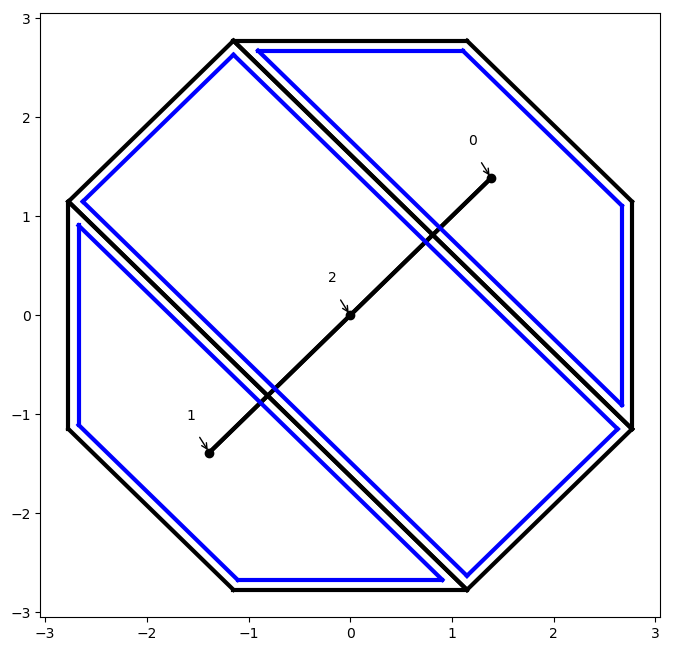

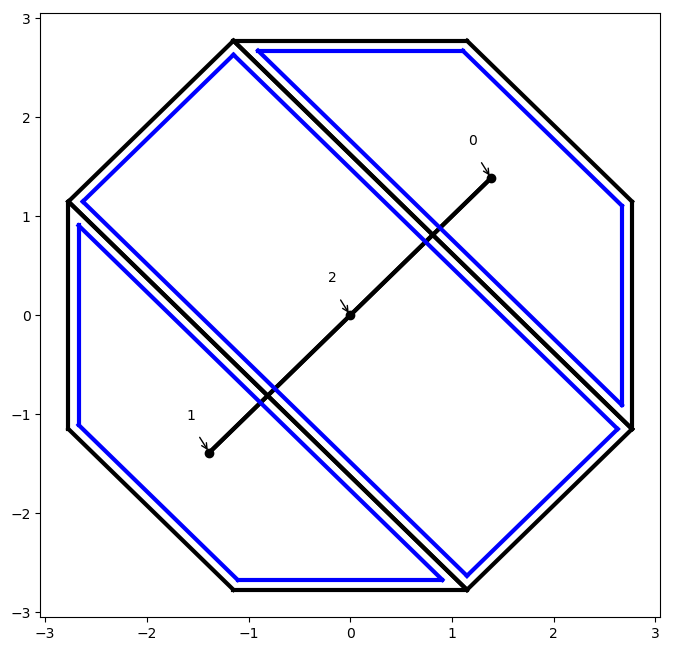

In [6]:
def scene():
    a = vec3.O().ring(3, 8)
    
    pg = planargraph(segs=list(slide(a, 2)))
    pg.ae(0, 3)
    pg.ae(4, 7)

    pg2 = pg.cp()
    vec3.Z(1.1).trnps(pg2.vertices)
    
    #f, ax = plot()
    #plot_pg(ax, pg)
    
    pgs = [pg, pg2]
    
    controls = pginterior(pgs)
    
    #controls = controls[:32]
    print(controls)

    r = TForm(metas=[MetaMesh(c) for c in controls])
    ms = MetaScene(r)
    show(ms)

scene()

# pg -> walls, crowns, floors 

In [2]:
def example_metas():
    a = vec3.O(   ).ring(5, 4, True)
    b = vec3.Z(1.0).ring(5, 4, True)
    c = vec3.Z(1.0).ring(4, 4, True)
    d = vec3.Z(0.9).ring(5, 4, True)
    e = vec3.Z(0.9).ring(4, 4, True)
    
    tex = ParamMesh.textured(texture='generic_4')

    mesh = Mesh()
    mesh._railings = []
    mesh._stairs = []


    bot = mesh.af(a, meta=tex)
    top = mesh.apy((b, (c, )), meta=tex)
    mesh.apy((d[::-1], (e[::-1], )), meta=tex)
    mesh.bridge(d, b)
    mesh.bridge(c, e)

    sup = mesh.perimeter(top)[1]
    mesh._railings.extend(sup)
    mesh._stairs.append((bot, sup[0]))
    mesh._stairs.append((bot, sup[2]))


    ground = MetaMesh(mesh)
    stairs = Stairs(mesh)
    railing = Railing(mesh)
    return [ground, stairs, railing]

m = example_metas()
r = TForm(metas=m)
ms = MetaScene(r)
show(ms)

Loaded texture: generic_0 (../resources/textures/generics/generic_0.png)
Loaded texture: generic_4 (../resources/textures/generics/generic_4.png)
Loaded texture: generic_8 (../resources/textures/generics/generic_8.png)


In [8]:
"""
stairs connect one edge to another edge requiring an inherit turn of up to pi either leftward or rightward
"""

class Stairs(MetaMesh):
    
    def scene(self):
        vs = self.control.vertices
        wires = []
        chunks = []
        
        n = 3
        
        dZ = vec3.Z(0.1)
        for (u, v), (p, q) in self.control._stairs:
            self.control._railings.append((u, p))
            self.control._railings.append((v, q))

            u = vs[u] if isinstance(u, int) else u
            v = vs[v] if isinstance(v, int) else v
            p = vs[p] if isinstance(p, int) else p
            q = vs[q] if isinstance(q, int) else q

            lb = u.line(p, n, True)
            rb = v.line(q, n, True)
            for a, b in zip(lb, rb):
                wires.append((a, b))
            
            ll = [lb[0], lb[-1], lb[-1] - dZ, lb[0] - dZ]
            rl = [rb[0], rb[-1], rb[-1] - dZ, rb[0] - dZ]
            ramp = Mesh()
            ramp.bridge(rl, ll)
            ramp.af(ll)
            ramp.af(rl[::-1])
            ramp = Model(meshes={'generic_10': [ramp]})
            chunks.append(TForm(models=[ramp]))
            #wires.append((u, v))
            #wires.append((p, q))

            w = u.lerp(v, 0.5)
            r = p.lerp(q, 0.5)
            N = vec3.Z().crs(v - u).nrm()
            M = vec3.Z().crs(q - p).nrm()
            wires.append((w, w + N))
            wires.append((r, r + M))
        
        #wires.extend(self.control.fwires(TForm()))

        guide = Mesh()
        guide.wires = lambda tf: [tf.transform(wire) for wire in wires]
        guide = Model(meshes={'generic_10': [guide]})

        return TForm(children=chunks, models=[guide])

    
def scene():
    C = Mesh.cube_mesh(1)
    C.edgeloopsplit(0, 1)
    
    u = ( 0, 8)
    v = (11, 6)
    
    C._railings = []
    C._stairs = [(u, v)]

    show(MetaScene(TForm(metas=[Stairs(C), Railing(C)])))
    
scene()

Loaded texture: generic_10 (../resources/textures/generics/generic_10.png)
Loaded texture: generic_8 (../resources/textures/generics/generic_8.png)
